In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json


# diseases codes website (precise) : https://www.aapc.com/codes/icd9-codes/250.93
# diseases codes lookup table (does not contain all codes) : https://www.aafp.org/fpm/icd9/icd9-short.pdf#

# Define functions

In [2]:
def create_get_value_fn(mapping):
    def get_value(row, default_value:str = "250"):
        for val in [row['diag_1'], row['diag_2'], row['diag_3']]:
            if val in list(mapping.keys()):
                return val
        return default_value
    return get_value

# Create and display pie chart with value + percent labels
def autopct_format(values):
    def autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return autopct


def do_pie_chart(data: pd.DataFrame, title: str=f'Overall readmission status distribution', column_to_count_on:str = "readmitted_binary", counted_values:list = [0, 1], ax: plt.axes = None, fig_path: str = None):

    if ax is None:
        fig, ax = plt.subplots(figsize = (5, 5))
        plt.title(title)
    else:
        ax.set_title(title)

    # Count occurrences
    counts = data.copy()[column_to_count_on].value_counts().reindex(counted_values, fill_value=0)

    counts.index = ["readmitted" if i == 1 else "not readmitted" for i in counts.index]

    counts.plot.pie(
        labels=counts.index,
        autopct=autopct_format(counts),
        ylabel='',
        startangle=90,
        counterclock=False,
        shadow=False,
        ax=ax
    )

    plt.tight_layout()

    if fig_path is not None:
        fig.savefig(fig_path)

    return plt.gcf(), plt.gca()

# Data reading

In [3]:
data = pd.read_csv("../data/processed/diabetes_cleaned_data.csv")
data["diab_complication_categories"] = data["diab_complication_categories"].fillna("None")
print(data.columns)
print(data.head())

Index(['patient_nbr', 'encounter_id', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'diag_1_category', 'diag_2_category', 'diag_3_category', 'diab_code',
       'diab_type', 'diab_control', 'diab_complication_binary',
       'diab_complic

# New diabetes related features relation with target feature

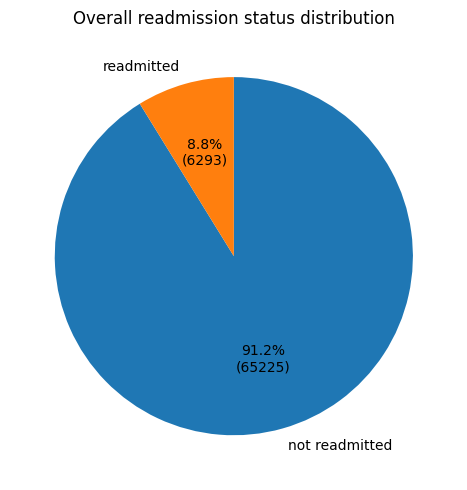

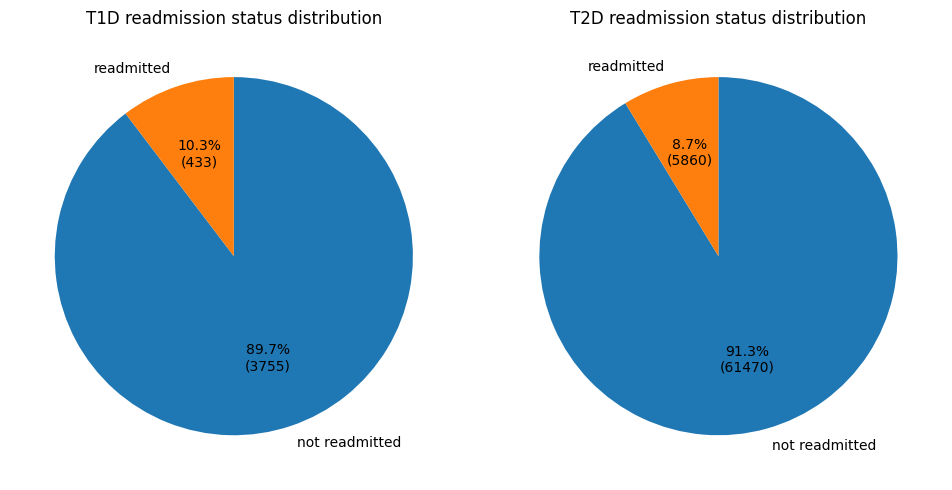

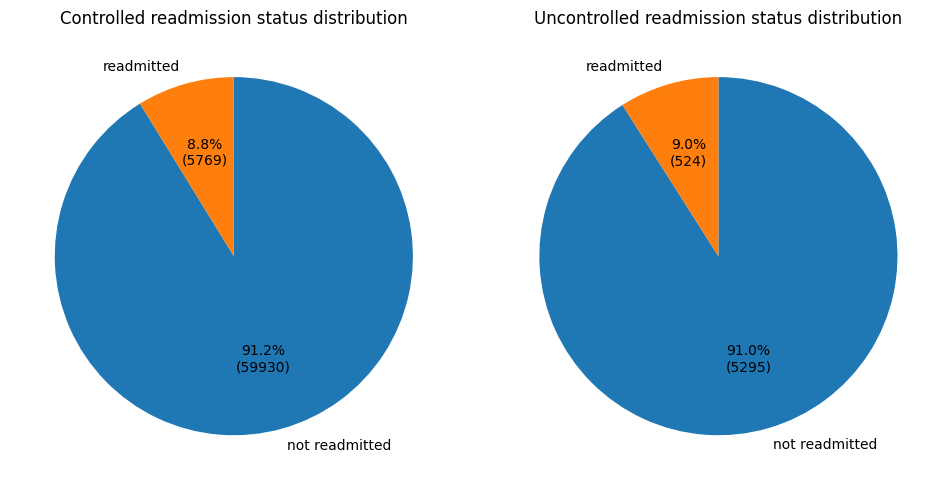

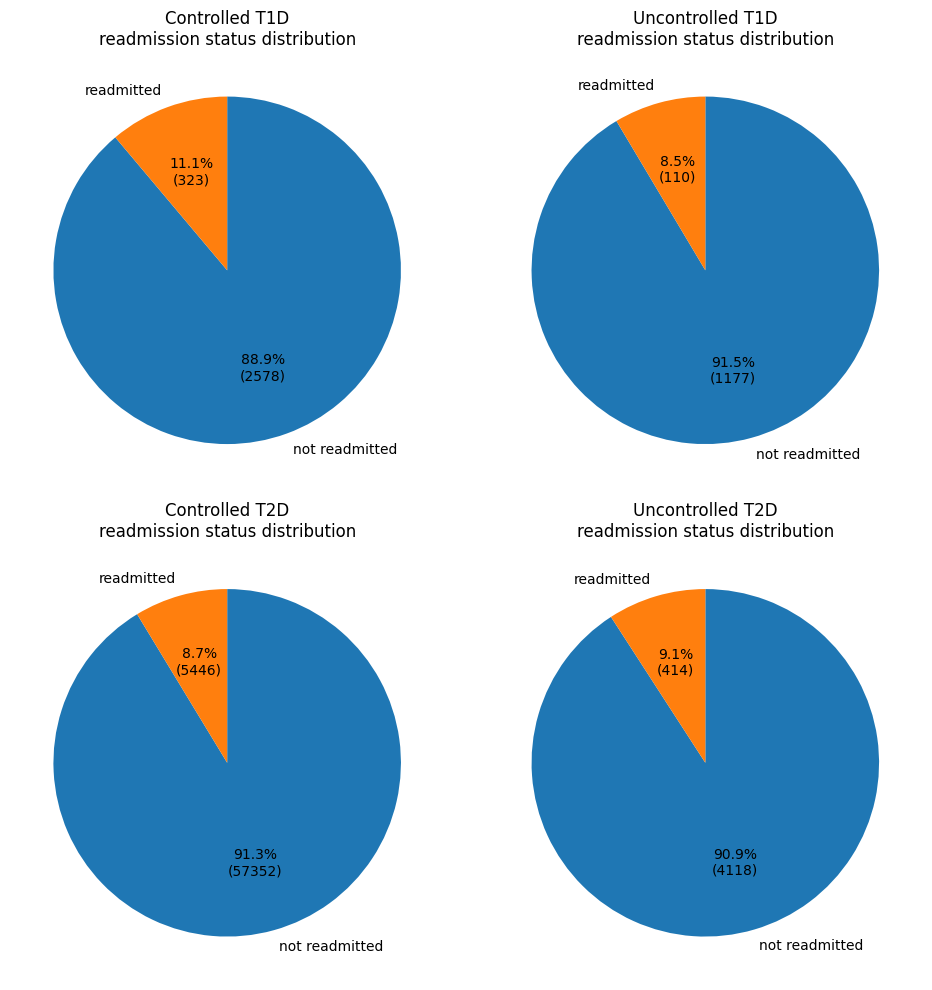

In [4]:
# Overall readmission status distribution
fig, ax = do_pie_chart(data=data, fig_path="../figures/diabetes_param_impact/overall.png")

# per diabetes type readmisison status distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
for ax, (diabetes_name, diabetes_value) in zip(axs, [("T1D", 1), ("T2D", 2)]):
    do_pie_chart(data=data.copy()[data.diab_type == diabetes_value], title=f"{diabetes_name} readmission status distribution", ax=ax)
plt.savefig("../figures/diabetes_param_impact/diabetes_type.png")

# per control level readmission status distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
for ax, (control_level_name, control_level_value) in zip(axs, [("Controlled", 1), ("Uncontrolled", 0)]):
    do_pie_chart(data=data.copy()[data.diab_control == control_level_value], title=f"{control_level_name} readmission status distribution", ax=ax)
plt.savefig("../figures/diabetes_param_impact/control_status.png")

# per diabetes type and control level readmission status distribution
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

i = 0
for diabetes_name, diabetes_value in [("T1D", 1), ("T2D", 2)]:
    for control_level_name, control_level_value in [("Controlled", 1), ("Uncontrolled", 0)]:
        do_pie_chart(data=data.copy()[(data.diab_control == control_level_value) & (data.diab_type == diabetes_value)], title=f"{control_level_name} {diabetes_name}\nreadmission status distribution", ax=axs[i])
        i += 1
plt.savefig("../figures/diabetes_param_impact/diabetes_type_control_status.png")

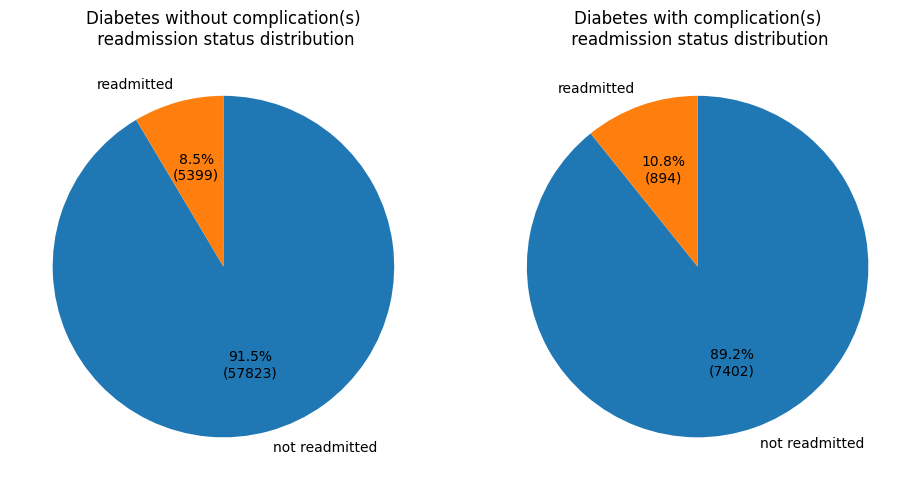

In [5]:
# per control level readmission status distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()
for ax, (complication_binary_name, complication_binary_value) in zip(axs, [("Diabetes without complication(s)\n", 0), ("Diabetes with complication(s)\n", 1)]):
    do_pie_chart(data=data.copy()[data.diab_complication_binary == complication_binary_value], title=f"{complication_binary_name} readmission status distribution", ax=ax)
plt.savefig("../figures/diabetes_param_impact/complications_binary.png")

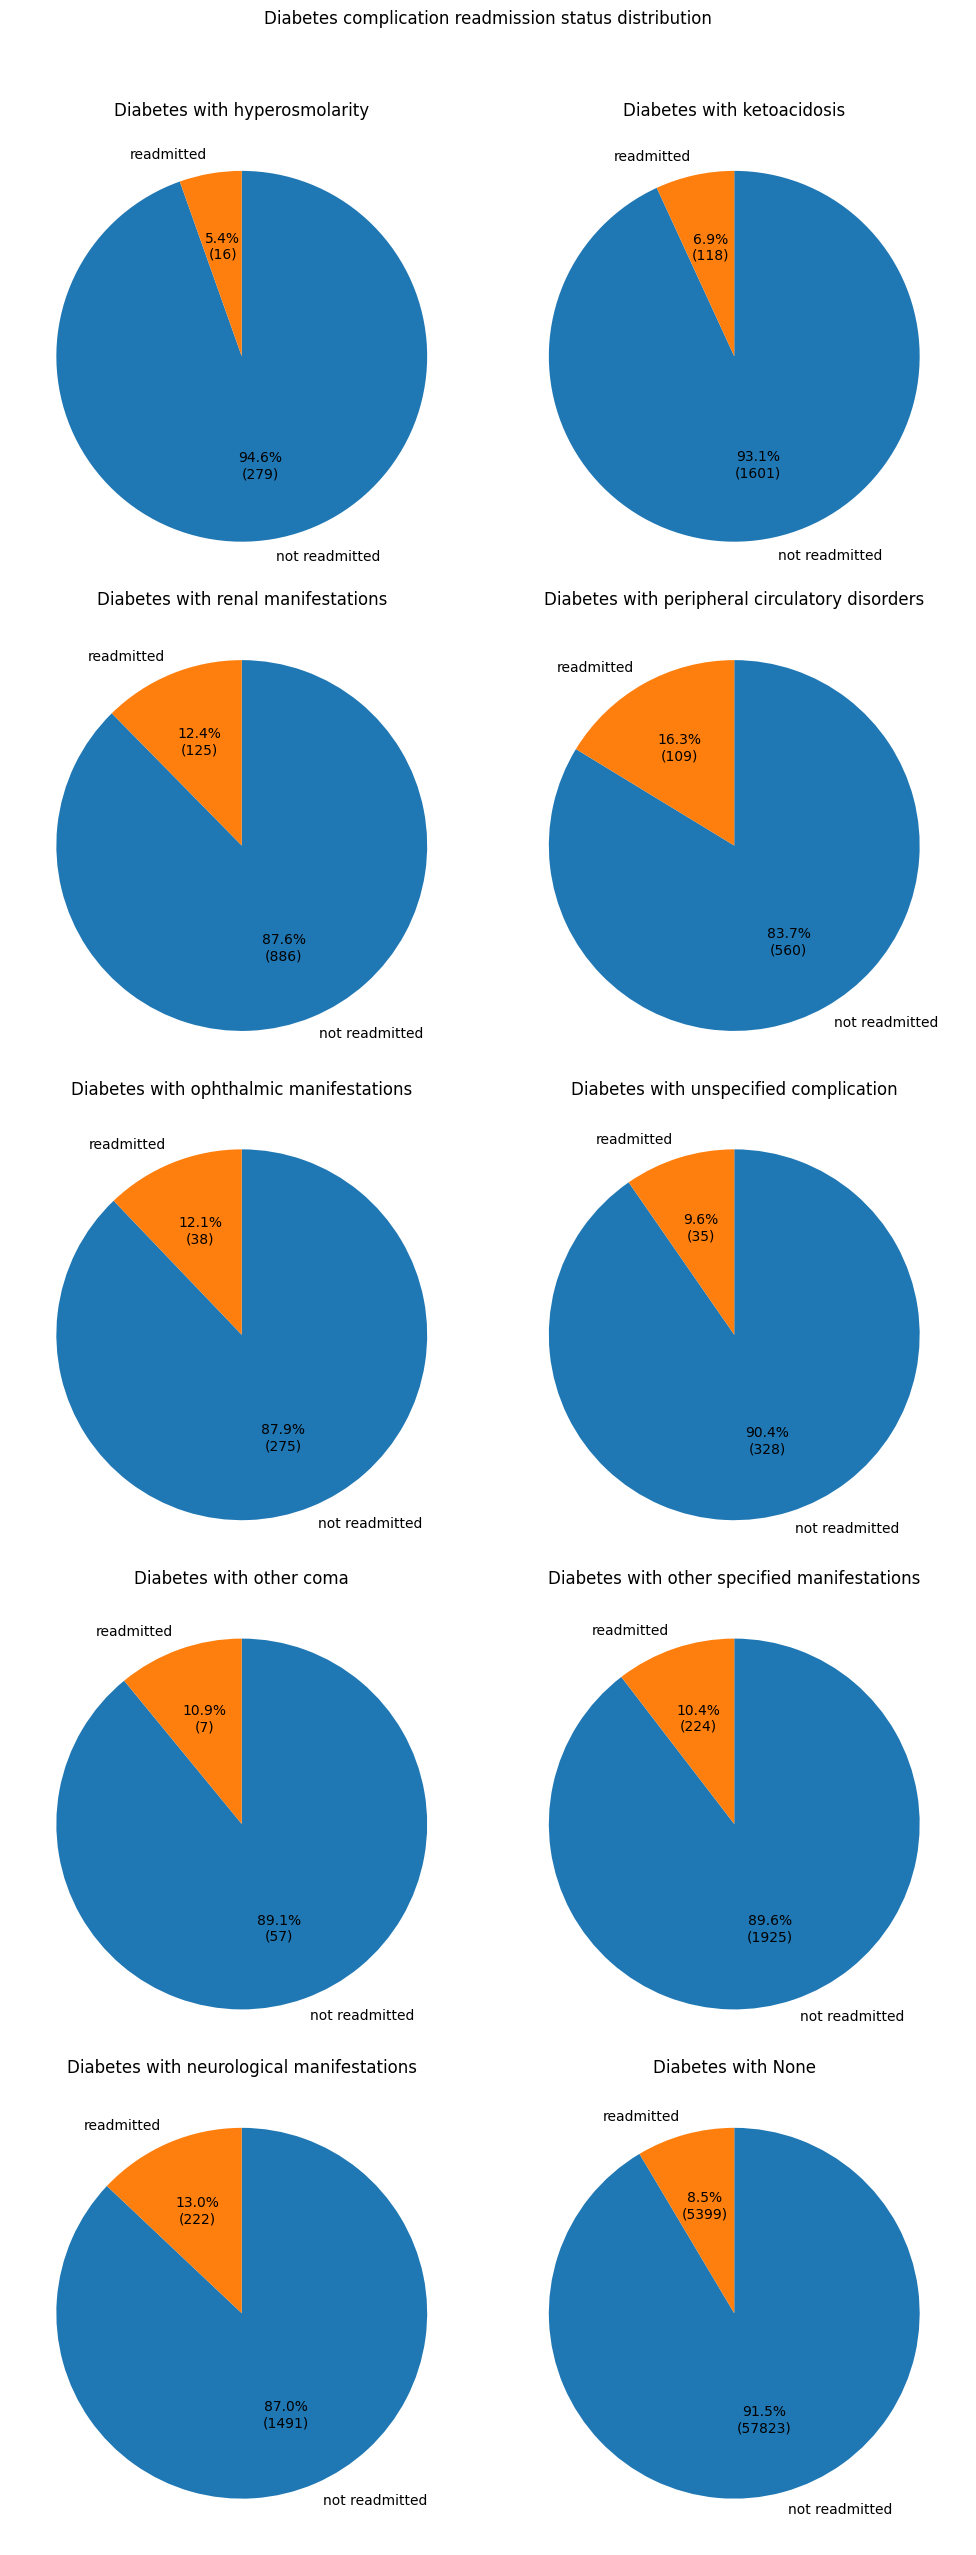

In [6]:
# per complication status distribution
fig, axs = plt.subplots(5, 2, figsize=(10, 25))
axs = axs.flatten()
for ax, complication in zip(axs, list(set(data.diab_complication_categories.values))):
    selected_data = data.copy()[data.diab_complication_categories == complication]
    if len(selected_data.index) > 0:
        do_pie_chart(data=selected_data, title=f"Diabetes with {complication}", ax=ax)
    plt.gcf().suptitle(f"Diabetes complication readmission status distribution", y=1.02)
    plt.savefig("../figures/diabetes_param_impact/complications_categories.png")

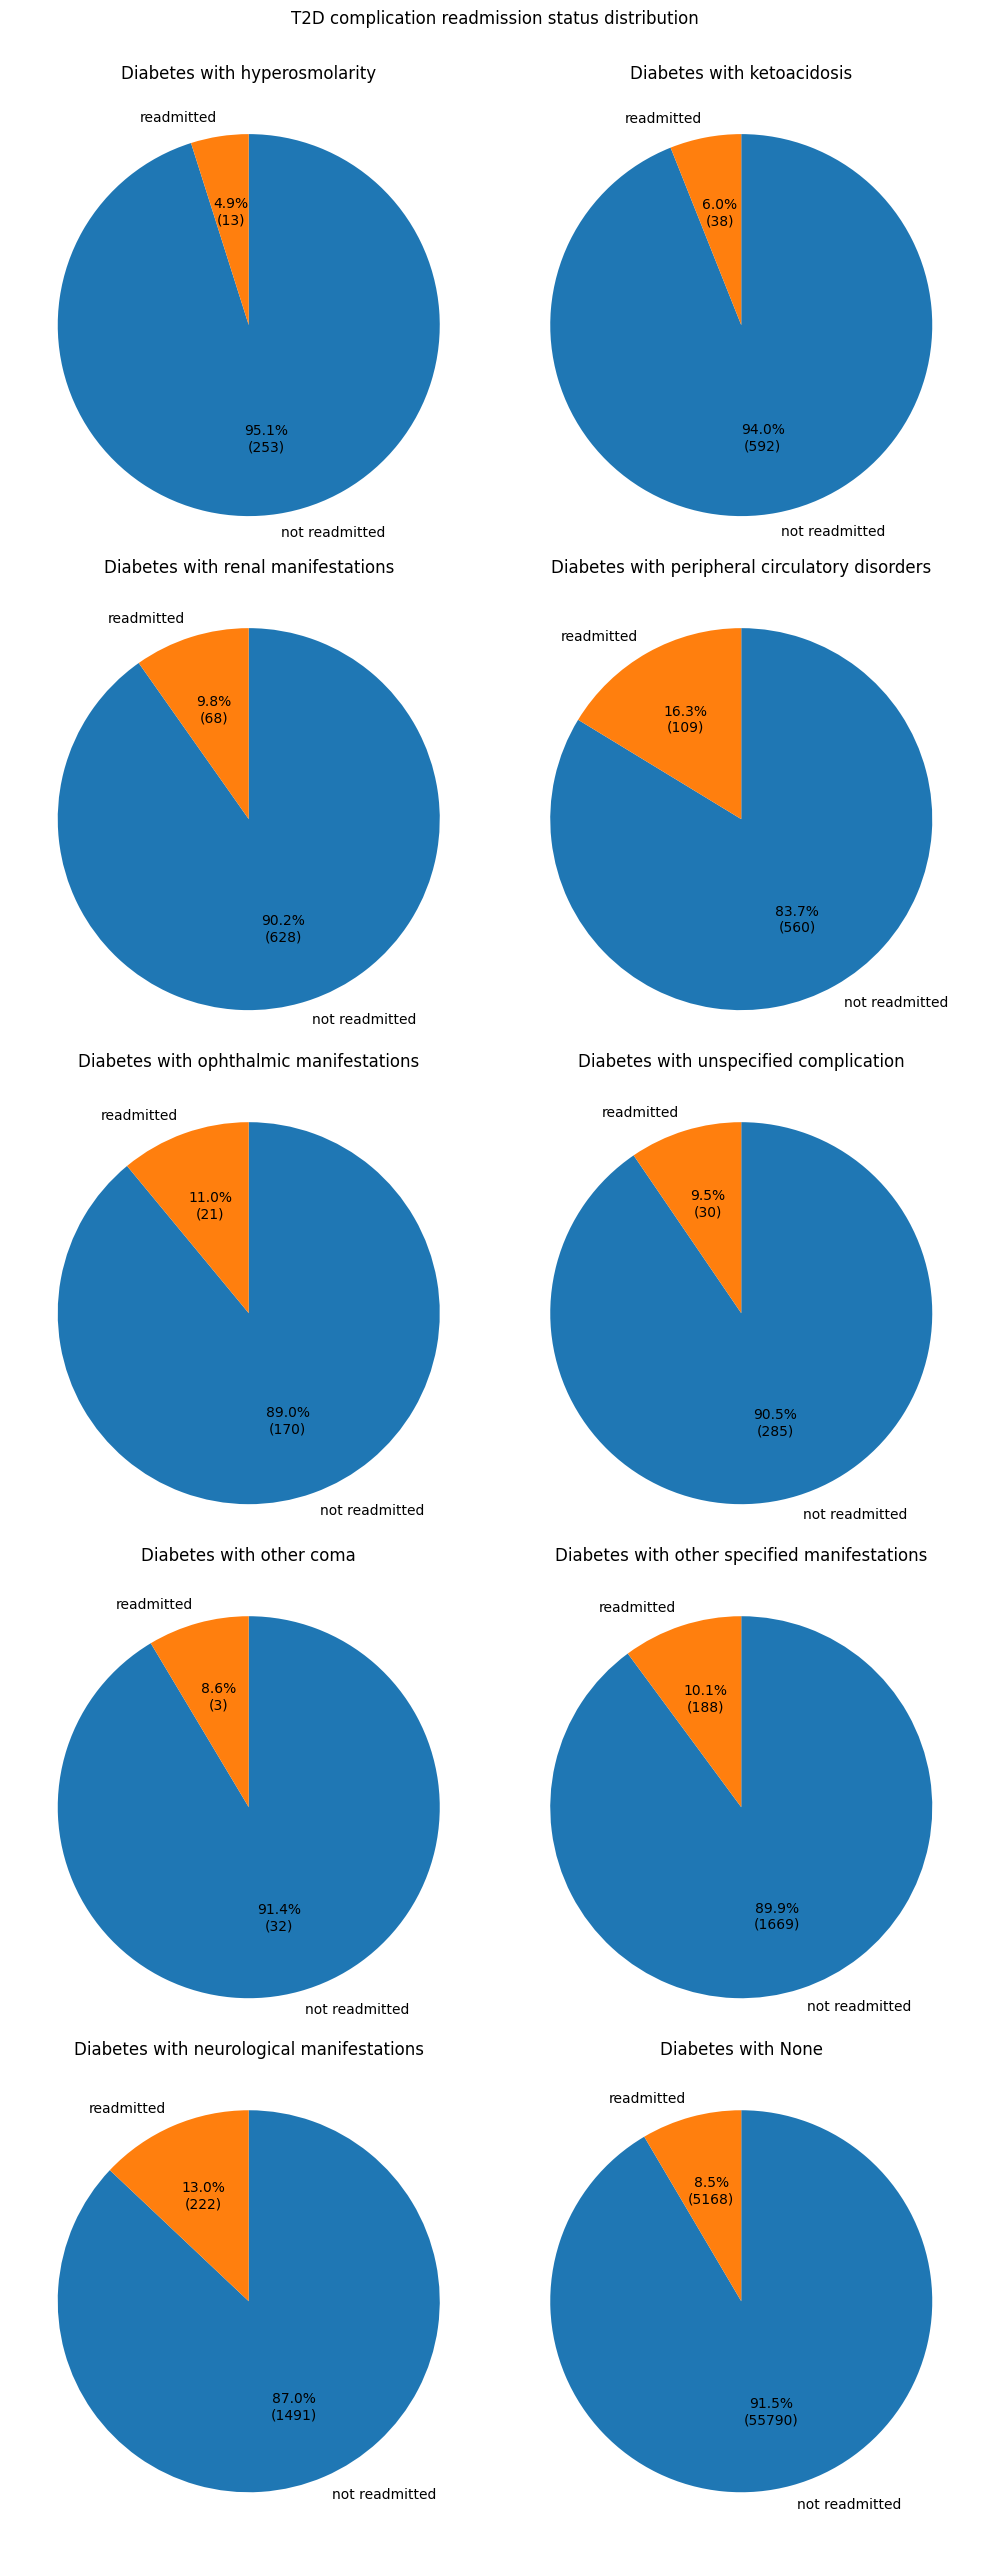

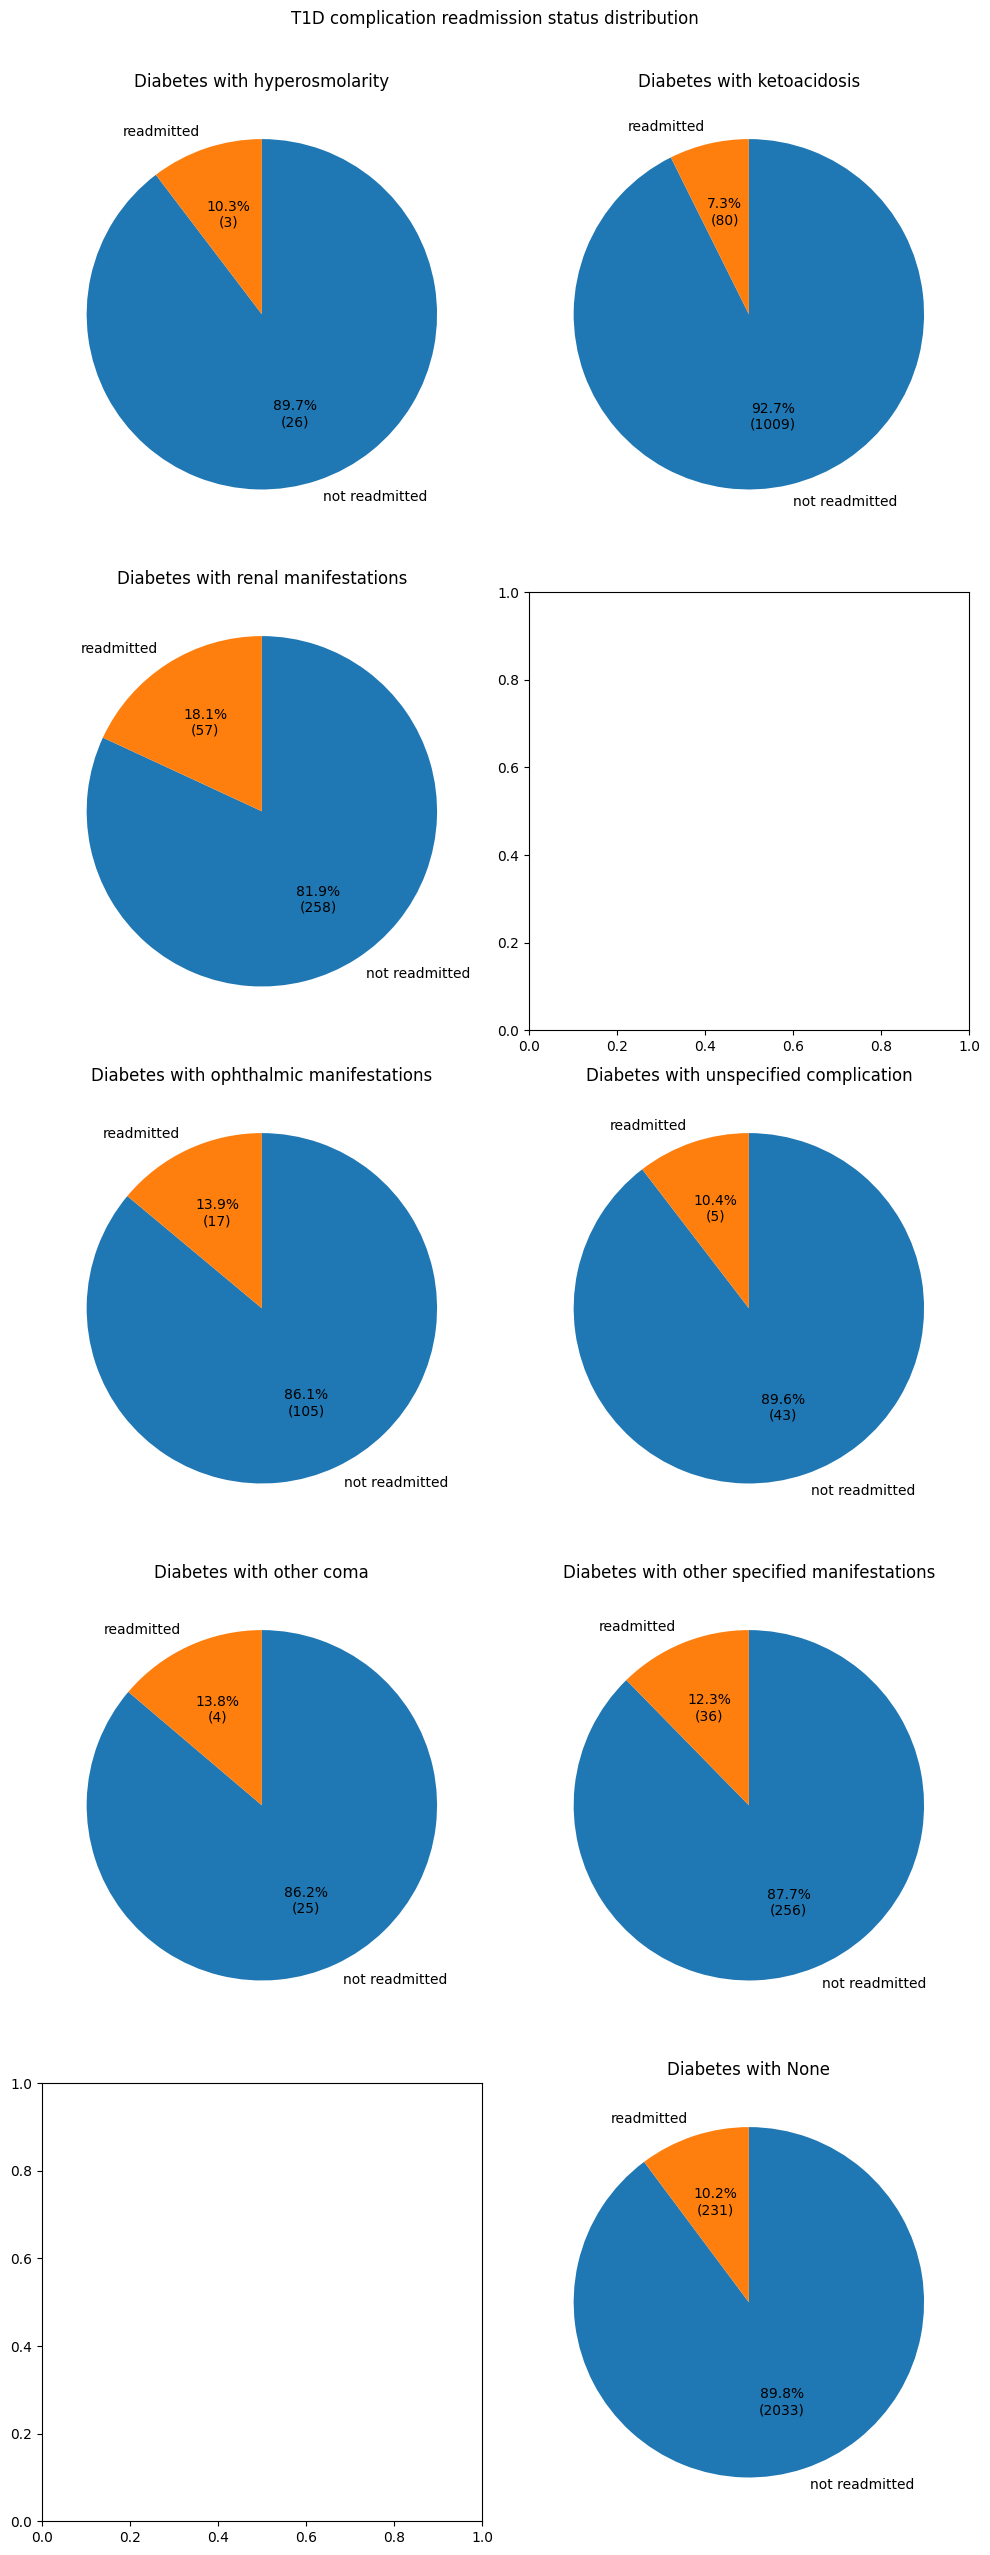

In [7]:
# per complication status distribution
complications_categories = list(set(data.diab_complication_categories.values))
for diab_type in [2, 1]:
    fig, axs = plt.subplots(5, 2, figsize=(10, 25))
    axs = axs.flatten()
    for ax, complication in zip(axs, complications_categories):
        selected_data = data.copy()[(data.diab_complication_categories == complication) & (data.diab_type == diab_type)]
        if len(selected_data.index) > 0:
            do_pie_chart(data=selected_data, title=f"Diabetes with {complication}", ax=ax)
    plt.gcf().suptitle(f"T{diab_type}D complication readmission status distribution", y=1.02)
    plt.gcf().savefig(f"../figures/diabetes_param_impact/t{diab_type}_complication_categories.png")